# Text Classification with RNN

This uses the fake news and real news dataset on kaggle. You can download the data here:
https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [1]:
# load packages
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence


/home/vector/anaconda3/envs/KerasGPU2.2.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vector/anaconda3/envs/KerasGPU2.2.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vector/anaconda3/envs/KerasGPU2.2.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vector/anaconda3/en

In [2]:
# load data
fake_news = pd.read_csv('../../Data/FakeNews/Fake.csv')
true_news = pd.read_csv('../../Data/FakeNews/True.csv')

# add the classification to the pandas dataframe
fake_news['true'] = 1
true_news['true'] = 0

# Merge data into one dataframe
news = pd.concat([true_news[['text', 'true']], fake_news[['text', 'true']]])

# split into train test validate
train, test_val = train_test_split(news, test_size=0.2)
test, val = train_test_split(test_val, test_size=0.5)

# Tokenizing

In [3]:
#%% tokenize data
max_length = 500
max_words = 1000
tokenizer = Tokenizer(num_words = max_words, oov_token = '<OOV>')

# don't include training or test data in word index
tokenizer.fit_on_texts(train['text'].values) 

# tokenize
sequences = tokenizer.texts_to_sequences(train['text'].values)
test_sequences = tokenizer.texts_to_sequences(test['text'].values)
val_sequences = tokenizer.texts_to_sequences(val['text'].values)

# pad to same length
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_length)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_length)
val_sequences_matrix = sequence.pad_sequences(val_sequences, maxlen=max_length)



# Build model

In [4]:
def build_model(num_outputs = 1):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(max_words, 64, input_length=max_length))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(num_outputs))
    
    return model

model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 64)           64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)      

In [5]:
# compile model    
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Train


In [6]:
# train
history = model.fit(sequences_matrix,
                    train['true'].values,
                    validation_data = ([val_sequences_matrix, val['true'].values]),
                    batch_size = 128,
                    epochs = 5)
    

Train on 35918 samples, validate on 4490 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
35918/35918 [==============================] - 241s 7ms/sample - loss: 1.9632 - acc: 0.4780 - val_loss: 1.1540 - val_acc: 0.4753
Epoch 2/5
35918/35918 [==============================] - 237s 7ms/sample - loss: 0.8898 - acc: 0.4860 - val_loss: 0.7066 - val_acc: 0.5020
Epoch 3/5
35918/35918 [==============================] - 238s 7ms/sample - loss: 0.6776 - acc: 0.5675 - val_loss: 0.6092 - val_acc: 0.6468
Epoch 4/5
35918/35918 [==============================] - 238s 7ms/sample - loss: 0.5529 - acc: 0.7076 - val_loss: 0.4093 - val_acc: 0.8521
Epoch 5/5
35918/35918 [==============================] - 237s 7ms/sample - loss: 3.6225 - acc: 0.7147 - val_loss: 4.8373 - val_acc: 0.6699


# Error Metrics

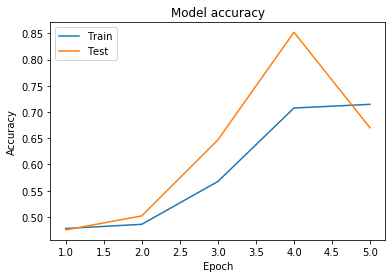

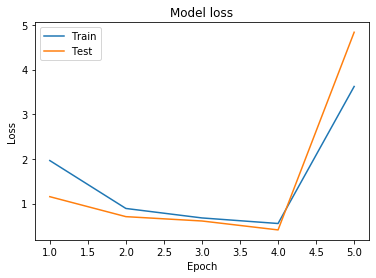

In [7]:

def plotHistory(history):
    ''' This function plots the training and validation loss and accuracy. This code has been writen in the Keras
    documentation which is very useful. 
    '''
    # Plot training & validation accuracy values
    plt.plot(np.arange(1,len(history.history['acc'])+1), history.history['acc'])
    plt.plot(np.arange(1,len(history.history['acc'])+1),history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(np.arange(1,len(history.history['acc'])+1),history.history['loss'])
    plt.plot(np.arange(1,len(history.history['acc'])+1),history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# show the training history in a plot.
plotHistory(history)


In [8]:
# we will input x_test data in to model, and get the predicted labels
predictions = model.predict(test_sequences_matrix)


              precision    recall  f1-score   support

           0       0.85      0.35      0.49      2115
           1       0.62      0.95      0.75      2375

    accuracy                           0.66      4490
   macro avg       0.74      0.65      0.62      4490
weighted avg       0.73      0.66      0.63      4490



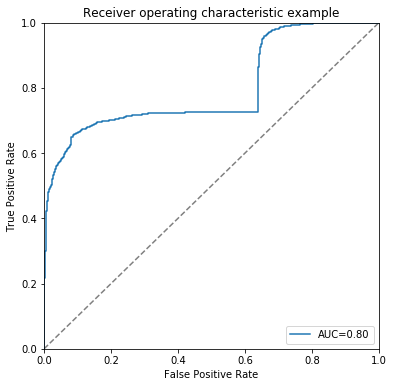

In [16]:
# print classification report
print(classification_report(test['true'].values, predictions>0.5))

# create AUC plots
def PlotAUC(y_truth, y_pred):
    # set up plot
    plt.figure(figsize=(6,6))  
    plt.xlim([0,1])           
    plt.ylim([0,1])           

    plt.plot([0,1],[0,1], linestyle='--', color = 'grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    
    fpr, tpr, thresholds = metrics.roc_curve(y_truth.flatten(), y_pred.flatten())
    AUC = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = 'AUC={:.2f}'.format(AUC))
    plt.legend(loc="lower right")
    
    plt.show()
    
PlotAUC(test['true'].values, predictions)

In [10]:
# print text, it's label, and model prediction
prediction_index = 5
print(test['text'].values[prediction_index])
print(test['true'].values[prediction_index])
print(predictions[prediction_index])
    

WASHINGTON (Reuters) - The U.S. House of Representatives on Thursday narrowly approved a bill to repeal Obamacare, handing Republican President Donald Trump a victory that could prove short-lived as the healthcare legislation heads into a likely tough battle in the Senate. The vote to repeal former President Barack Obama’s signature domestic achievement, which enabled 20 million more Americans to get health insurance, was Trump’s biggest legislative win since he took office in January, putting him on a path to fulfilling one of his key campaign promises as well as a seven-year quest by Republican lawmakers. It marked a reversal of fortune for the Republican president who suffered a stunning defeat in late March when House Republican leaders pulled legislation to scrap Obamacare after they and the White House could not resolve the clashing interests of Republican moderates and the party’s most conservative lawmakers. Trump has called Obamacare a “disaster” and congressional Republicans 